In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

seed = 2023
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.experimental.numpy.random.seed(seed)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
# Set a fixed value for the hash seed
os.environ["PYTHONHASHSEED"] = str(seed)
import dolfin as df
import time
from utils import *
from utils_training import *
import prepare_data
from utils_compare_methods import *
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import vedo
import vedo.dolfin as vdf
from prepare_data import rotate, outside_ball
import pandas as pd

sns.set_theme()
sns.set_context("paper")
colors = sns.color_palette("mako").as_hex()
my_cmap = sns.color_palette("viridis", as_cmap=True)

%load_ext autoreload
%autoreload 2


Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
save_figs = True
small_data = False
level = 1
data = DataLoader(small_data)
agent = Agent(data, loss_level=level)

if not (os.path.exists(f"./images/")) and save_figs:
    os.makedirs(f"./images/")


file = open("./models/best_model/best_epoch.txt")
for y in file.read().split(" "):
    if y.isdigit():
        best_epoch = int(y)
print(f"{best_epoch=}")


max_norm_F : 65.79521
data_size,nb_val,nb_train: 1500 187 1313
data shape: (None, 64, 64, 4)
FNO2d model created with hyperparameters : modes:10, width:20, pad_prop:0.05 
best_epoch=1830


In [3]:
nb_epochs = best_epoch
agent.model.load_weights(f"./models/model_{nb_epochs}/model_weights")

# Compare the errors of $\phi$-FEM, standard FEM and FNO with respect to a reference fine standard FEM solution

In [4]:
def compare_std_phi_fem_and_fno(param, Plot=False, epoch=best_epoch):
    agent.model.load_weights(f"./models/model_{epoch}/model_weights")

    standard_solver = StandardFEMSolver(params=param)
    solver = PhiFemSolver_error(nb_cell=64 - 1, params=param)
    mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta = param[0]

    u_ref, V_ref, dx_ref = standard_solver.solve_one(0, None, True)
    (
        u_phi_fem,
        V_phi_fem,
        dx_phi_fem,
        _h_phi,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
    ) = solver.solve_one(0)

    (
        u_std,
        _h_std,
        construction_time_standard,
        resolution_time_standard,
    ) = standard_solver.solve_one(0, 64, False)

    F = generate_F_numpy(mu0, mu1, sigma, 64) / data.max_norm_F
    G = generate_G_numpy(alpha, beta, 64)
    phi = generate_phi_numpy(x_0, y_0, lx, ly, theta, 64)
    X = generate_manual_new_data_numpy(phi, F, G)
    start_call = time.time()
    Y = agent.model.call(X)
    end_call = time.time()
    time_fno = end_call - start_call
    predicted_solution = X[:, :, :, 1] * Y[:, :, :, 0] + X[:, :, :, 2]
    predicted_solution = np.reshape(predicted_solution, (64, 64))
    predicted_sol_fenics = convert_numpy_matrix_to_fenics(
        predicted_solution, 64, 1
    )

    u_phi_fem_proj = df.project(
        u_phi_fem,
        V_ref,
        solver_type="gmres",
        preconditioner_type="hypre_amg",
    )

    l2_error_phi_fem = (
        df.assemble((((u_ref - u_phi_fem_proj)) ** 2) * dx_ref) ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    u_std_fem_proj = df.project(
        u_std, V_ref, solver_type="gmres", preconditioner_type="hypre_amg"
    )
    l2_error_std_fem = (
        df.assemble((((u_ref - u_std_fem_proj)) ** 2) * dx_ref) ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    predicted_sol_fenics_proj_V_ref = df.project(
        predicted_sol_fenics,
        V_ref,
        solver_type="gmres",
        preconditioner_type="hypre_amg",
    )

    l2_error_fno = (
        df.assemble(
            (((u_ref - predicted_sol_fenics_proj_V_ref)) ** 2) * dx_ref
        )
        ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    if Plot:
        plt.figure(figsize=(16, 4))

        ax1 = plt.subplot(141)
        img = df.plot(u_ref, mode="color", cmap=my_cmap)
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("bottom", size="5%", pad=0.3)
        ax1.grid(False)
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_title("Reference solution", fontsize=15)
        plt.colorbar(img, cax=cax, orientation="horizontal")

        ax2 = plt.subplot(142)
        img = df.plot(u_phi_fem_proj, mode="color", cmap=my_cmap)
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("bottom", size="5%", pad=0.3)
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.grid(False)
        ax2.set_title(
            "$\phi$-FEM solution \n$L^2$ relative error : "
            + f"{l2_error_phi_fem:.5f}",
            fontsize=15,
        )
        plt.colorbar(img, cax=cax, orientation="horizontal")

        ax3 = plt.subplot(143)
        img = df.plot(u_std_fem_proj, mode="color", cmap=my_cmap)
        divider = make_axes_locatable(ax3)
        cax = divider.append_axes("bottom", size="5%", pad=0.3)
        ax3.grid(False)
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)
        ax3.set_title(
            "Standard FEM solution \n$L^2$ relative error : "
            + f"{l2_error_std_fem:.5f}",
            fontsize=15,
        )
        plt.colorbar(img, cax=cax, orientation="horizontal")

        ax4 = plt.subplot(144)
        img = df.plot(
            predicted_sol_fenics_proj_V_ref, mode="color", cmap=my_cmap
        )
        divider = make_axes_locatable(ax4)
        cax = divider.append_axes("bottom", size="5%", pad=0.3)
        ax4.grid(False)
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.set_title(
            "Predicted solution \n$L^2$ relative error : "
            + f"{l2_error_fno:.5f}",
            fontsize=15,
        )
        plt.colorbar(img, cax=cax, orientation="horizontal")
        if Plot and save_figs:
            plt.savefig(f"./images/example_output_FEMs_FNO.png")
        plt.show()

    print(f"{l2_error_fno=}")
    print(f"{l2_error_phi_fem=}")
    print(f"{l2_error_std_fem=}")

    print(f"{_h_std=}")
    print(f"{_h_phi=}")

    return (
        l2_error_phi_fem,
        l2_error_std_fem,
        l2_error_fno,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
        construction_time_standard,
        resolution_time_standard,
        time_fno,
    )

######  epoch=1830  Param : 1/5 ######
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.39319298  0.48073736  0.19530693  0.41949195  0.56682385  0.30490284
  0.22291918  0.58337006 -0.54067679  0.10377864]
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.39319298  0.48073736  0.19530693  0.41949195  0.56682385  0.30490284
  0.22291918  0.58337006 -0.54067679  0.10377864]
num of cell in the ghost penalty: 216
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.39319298  0.48073736  0.19530693  0.41949195  0.56682385  0.30490284
  0.22291918  0.58337006 -0.54067679  0.10377864]
Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 4599 nodes for 2300 points.


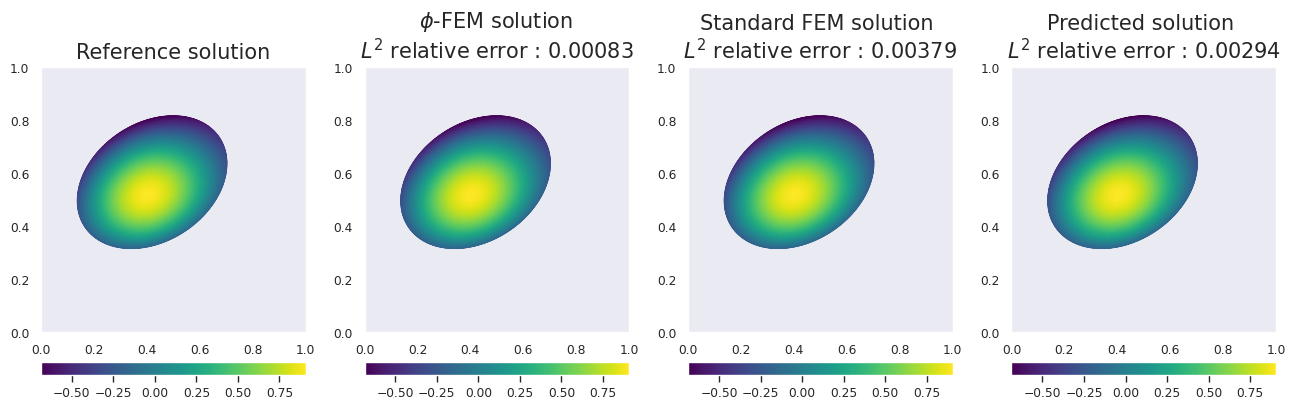

l2_error_fno=0.002935782648763972
l2_error_phi_fem=0.0008297511443960117
l2_error_std_fem=0.0037892681848398168
_h_std=0.021571610001223894
_h_phi=0.02244783432338254
l2_error_fno=0.002935782648763972
######  epoch=1830  Param : 2/5 ######
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.35042362  0.40378553  0.27036675  0.52091235  0.40445853  0.20458525
  0.35086316  0.24678663 -0.25926609 -0.47446161]
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.35042362  0.40378553  0.27036675  0.52091235  0.40445853  0.20458525
  0.35086316  0.24678663 -0.25926609 -0.47446161]
num of cell in the ghost penalty: 256
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.35042362  0.40378553  0.27036675  0.52091235  0.40445853  0.20458525
  0.35086316  0.24678663 -0.25926609 -0.47446161]
Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed bou

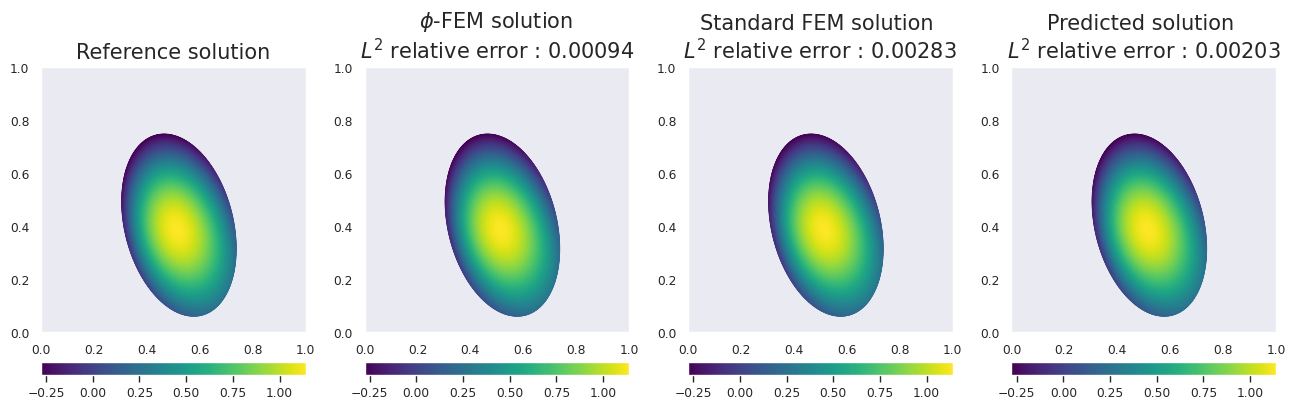

l2_error_fno=0.002031239571668395
l2_error_phi_fem=0.0009424970898309761
l2_error_std_fem=0.0028293418497890395
_h_std=0.021985728707074957
_h_phi=0.02244783432338254
l2_error_fno=0.002031239571668395
######  epoch=1830  Param : 3/5 ######
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.55283135  0.63636483  0.29790864  0.51119926  0.56444551  0.318704
  0.37739767  0.43299864 -0.51148275 -0.28703287]
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.55283135  0.63636483  0.29790864  0.51119926  0.56444551  0.318704
  0.37739767  0.43299864 -0.51148275 -0.28703287]
num of cell in the ghost penalty: 306
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.55283135  0.63636483  0.29790864  0.51119926  0.56444551  0.318704
  0.37739767  0.43299864 -0.51148275 -0.28703287]
Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed bounding 

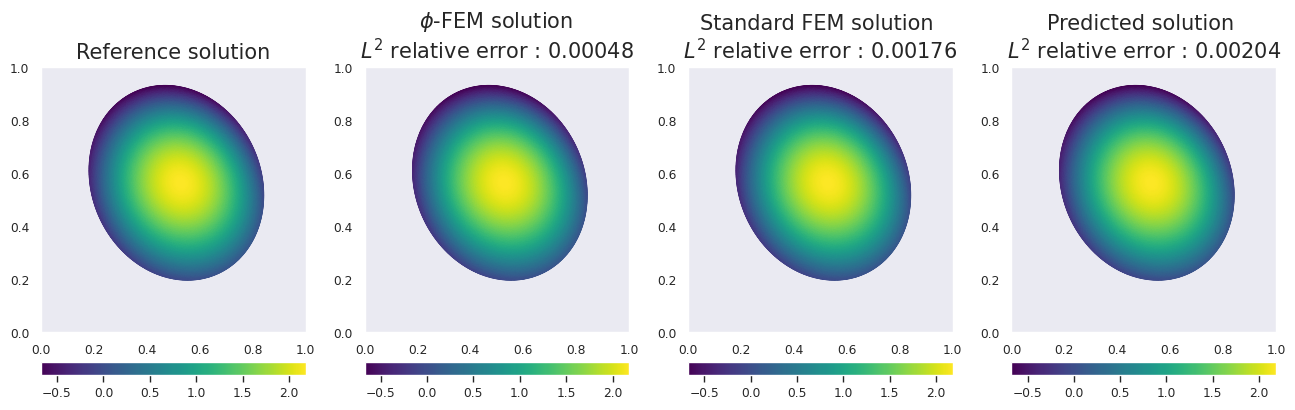

l2_error_fno=0.0020392861900196163
l2_error_phi_fem=0.0004803538973315404
l2_error_std_fem=0.0017555418963742153
_h_std=0.02227144783493767
_h_phi=0.02244783432338254
l2_error_fno=0.0020392861900196163
######  epoch=1830  Param : 4/5 ######
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.41013549  0.50357401  0.24367892  0.60399997  0.54228492  0.29432673
  0.27112824  0.39797249 -0.17441376 -0.19749795]
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.41013549  0.50357401  0.24367892  0.60399997  0.54228492  0.29432673
  0.27112824  0.39797249 -0.17441376 -0.19749795]
num of cell in the ghost penalty: 242
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.41013549  0.50357401  0.24367892  0.60399997  0.54228492  0.29432673
  0.27112824  0.39797249 -0.17441376 -0.19749795]
Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed bo

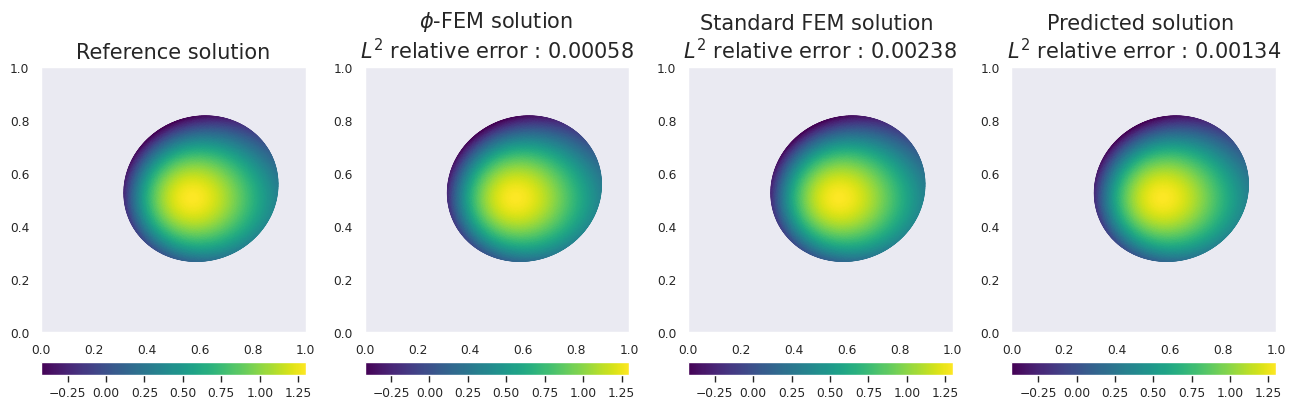

l2_error_fno=0.001337413165882104
l2_error_phi_fem=0.0005847371627831653
l2_error_std_fem=0.0023763160321296144
_h_std=0.022344735548300285
_h_phi=0.02244783432338254
l2_error_fno=0.001337413165882104
######  epoch=1830  Param : 5/5 ######
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.28480473  0.52696114  0.17714624  0.46532863  0.43279133  0.2702816
  0.2238325   0.13093516 -0.74296286 -0.50551337]
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.28480473  0.52696114  0.17714624  0.46532863  0.43279133  0.2702816
  0.2238325   0.13093516 -0.74296286 -0.50551337]
num of cell in the ghost penalty: 210
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.28480473  0.52696114  0.17714624  0.46532863  0.43279133  0.2702816
  0.2238325   0.13093516 -0.74296286 -0.50551337]
Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed boundi

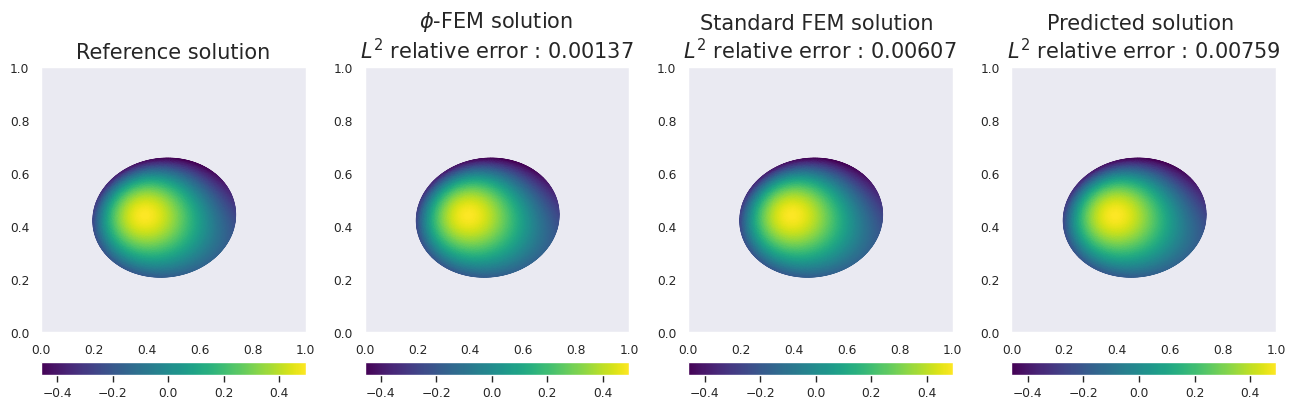

l2_error_fno=0.0075865604155639045
l2_error_phi_fem=0.0013723066179048822
l2_error_std_fem=0.0060710514664055895
_h_std=0.02238767579742268
_h_phi=0.02244783432338254
l2_error_fno=0.0075865604155639045


In [5]:
F, phi, G, params = new_create_FG_numpy(5, 64)
i = 0
for i in range(len(params)):
    for epoch in [best_epoch]:
        print(f"######  {epoch=}  Param : {i+1}/{np.shape(params)[0]} ######")
        (
            l2_error_phi_fem,
            l2_error_std_fem,
            l2_error_fno,
            cell_selection_phi,
            submesh_construction_phi,
            ghost_cell_selection_phi,
            resolution_time_phi,
            construction_time_standard,
            resolution_time_standard,
            time_fno,
        ) = compare_std_phi_fem_and_fno(
            np.array([params[i]]), True, epoch=epoch
        )
        print(f"{l2_error_fno=}")
    i += 1

In [ ]:
save_list_error = True
L2_error_fno, L2_error_phi_fem, L2_error_std_fem = [], [], []
Time_phi, Time_std, Time_fno = [], [], []

F, phi, G, params = new_create_FG_numpy(300, 64)
epoch = best_epoch
indices = list(range(0, len(params)))
for index in indices:
    print(f"Iter : {index+1}/{len(params)}")
    (
        l2_error_phi_fem,
        l2_error_std_fem,
        l2_error_fno,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
        construction_time_standard,
        resolution_time_standard,
        time_fno,
    ) = compare_std_phi_fem_and_fno(
        np.array([params[index]]), Plot=False, epoch=epoch
    )

    L2_error_phi_fem.append(l2_error_phi_fem)
    Time_phi.append(
        [
            cell_selection_phi,
            submesh_construction_phi,
            ghost_cell_selection_phi,
            resolution_time_phi,
        ]
    )
    L2_error_fno.append(l2_error_fno)
    Time_fno.append(time_fno)

    L2_error_std_fem.append(l2_error_std_fem)
    Time_std.append([construction_time_standard, resolution_time_standard])

    if save_list_error:
        np.save(
            "./L2_error_phi_fem.npy",
            np.array([L2_error_phi_fem]),
        )
        np.save(
            "./L2_error_std_fem.npy",
            np.array([L2_error_std_fem]),
        )
        np.save("./L2_error_fno.npy", np.array([L2_error_fno]))

In [ ]:
L2_error_phi_fem = np.load("./L2_error_phi_fem.npy")
L2_error_std_fem = np.load("./L2_error_std_fem.npy")
L2_error_fno = np.load("./L2_error_fno.npy")


In [ ]:
error_tab = []
error_tab.append(L2_error_phi_fem)
error_tab.append(L2_error_std_fem)
error_tab.append(L2_error_fno)
epoch = best_epoch
abs_str = ["$\phi$-FEM", "Standard FEM", "FNO " + str(epoch) + " epochs"]
errors = np.array(error_tab[:])
errors = np.reshape(errors, (3, np.shape(errors)[-1]))
print(np.shape(errors))
dataframe = pd.DataFrame(errors.transpose(), columns=abs_str)

sns.set(font_scale=1.1)

plt.figure(figsize=(6, 4))
sns.boxplot(data=dataframe, palette="ch:s=.0,rot=0.0,dark=0.5")
plt.yscale("log")
plt.xlabel("Method", fontsize=16)
plt.ylabel("Relative $L^2$ error", fontsize=16)
plt.grid(axis="y", visible=True, which="both")
plt.tight_layout()
if save_figs:
    plt.savefig(f"./images/boxplots_new_data_compare_method.png")
plt.show()

# Computation times for different sizes of input

In [ ]:
nb_epochs = best_epoch
agent.model.load_weights(f"./models/model_{nb_epochs}/model_weights")

In [ ]:
times, nb_data_call = [], []
times_phi_fem, times_std_fem = [], []

params_origin = np.array(
    [
        [
            0.58894387,
            0.45582733,
            0.24063726,
            0.60009858,
            0.4920412,
            0.28568717,
            0.24311015,
            0.0917393,
            -0.42856707,
            -0.34318572,
        ]
    ]
)
F_origin = generate_F_numpy(
    params_origin[0, 0], params_origin[0, 1], params_origin[0, 2], 64
)
phi_origin = generate_phi_numpy(
    params_origin[0, 3],
    params_origin[0, 4],
    params_origin[0, 5],
    params_origin[0, 6],
    params_origin[0, 7],
    64,
)
G_origin = generate_G_numpy(params_origin[0, -2], params_origin[0, -1], 64)

F = F_origin / data.max_norm_F
X = generate_manual_new_data_numpy(phi_origin, F, G_origin)
Y = agent.model.call(X)

solver = PhiFemSolver_error(nb_cell=64 - 1, params=params_origin[0])
standard_solver = StandardFEMSolver(params=params_origin[0])
mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta = params_origin[0]

(
    u_phi_fem,
    V_phi_fem,
    dx_phi_fem,
    _h_phi,
    cell_selection_phi,
    submesh_construction_phi,
    ghost_cell_selection_phi,
    resolution_time_phi,
) = solver.solve_one(0)

(
    u_std,
    _h_std,
    construction_time_standard,
    resolution_time_standard,
) = standard_solver.solve_one(0, 64, False)


nb_tests = 5
nb_data_call = [1, 5, 10, 20, 50, 100, 200, 500, 1000]
for i in nb_data_call:
    total_time_fno = 0.0
    F, phi, G, params = (
        np.repeat(F_origin, i, axis=0),
        np.repeat(G_origin, i, axis=0),
        np.repeat(phi_origin, i, axis=0),
        np.repeat(params_origin, i, axis=0),
    )
    F = F / data.max_norm_F
    X = generate_manual_new_data_numpy(phi, F, G)

    for k in range(nb_tests):
        print(f"### Call FNO  {i=}  {k=}  ###")
        start_call = time.time()
        Y = agent.model.call(X)
        end_call = time.time()
        total_time_fno += end_call - start_call
    average_time = total_time_fno / nb_tests
    times.append(average_time)
    time_phi_fem_total, time_standard, index = 0.0, 0.0, 0

    for k in range(nb_tests):
        index = 0
        for param in params:
            index += 1
            print(f"### Call PhiFEM : {index}/{len(params)}   {k=}  ###")
            solver = PhiFemSolver_error(nb_cell=64 - 1, params=param)
            (
                u_phi_fem,
                V_phi_fem,
                cell_selection_phi,
                submesh_construction_phi,
                ghost_cell_selection_phi,
                resolution_time_phi,
            ) = solver.solve_one(0)

            time_phi_fem_total += (
                cell_selection_phi
                + submesh_construction_phi
                + ghost_cell_selection_phi
                + resolution_time_phi
            )
    times_phi_fem.append(time_phi_fem_total / nb_tests)

    for k in range(nb_tests):
        index = 0

        for param in params:
            index += 1
            print(f"### Call Standard FEM : {index}/{len(params)}   {k=}  ###")
            standard_solver = StandardFEMSolver(params=param)
            (
                u_std,
                _h_std,
                construction_time_standard,
                resolution_time_standard,
            ) = standard_solver.solve_one(0, 64, False)

            time_standard += (
                resolution_time_standard + construction_time_standard
            )
    times_std_fem.append(time_standard / nb_tests)

In [ ]:
print(np.shape(nb_data_call))
print((times))
print(np.shape(times))

np.save("times_fno.npy", np.array([times]))
np.save("times_phifem.npy", np.array([times_phi_fem]))
np.save("times_stdfem.npy", np.array([times_std_fem]))

In [ ]:
times = np.load("times_fno.npy")
times_phi_fem = np.load("times_phifem.npy")
times_std_fem = np.load("times_stdfem.npy")

print(f"{np.shape(times)=}")
print(f"{np.shape(times_phi_fem)=}")
print(f"{np.shape(times_std_fem)=}")

In [ ]:
save_figs = True
plt.figure(figsize=(6, 4))
nb_data_call = np.array([1, 5, 10, 20, 50, 100, 200, 500, 1000])
indices = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
]
plt.loglog(nb_data_call[indices], times[0, indices], "-+", label="FNO")
plt.loglog(
    nb_data_call[indices], times_phi_fem[0, indices], "-+", label=r"$\phi$-FEM"
)
plt.loglog(
    nb_data_call[indices],
    times_std_fem[0, indices],
    "-+",
    label="Standard FEM",
)
plt.xlabel("Number of data")
plt.ylabel("Computation time (s)")
plt.legend()
if save_figs:
    plt.savefig(f"./images/compare_computation_times.png")
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
plt.loglog(
    nb_data_call[indices],
    [times_std_fem[0, i] / times[0, i] for i in indices],
    "-+",
    label="Standard FEM / FNO",
)
plt.loglog(
    nb_data_call[indices],
    [times_phi_fem[0, i] / times[0, i] for i in indices],
    "-+",
    label=r"$\Phi$-FEM / FNO",
)
plt.xlabel("Number of data", fontsize=16)
plt.ylabel("Ratio", fontsize=16)
plt.tight_layout()
plt.legend(fontsize=16)
if save_figs:
    plt.savefig(f"./images/compare_computation_times_ratio.png")
plt.show()

# Plot PhiFEM StdFEM FNO error time (convergence curves)

In [6]:
def compare_std_phi_fem_and_fno_size_error(
    param, size, u_ref, V_ref, dx_ref, epoch=2000
):
    solver = PhiFemSolver_error(nb_cell=size - 1, params=param)
    (
        u_phi_fem,
        V_phi_fem,
        dx_phi_fem,
        _h_phi,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
    ) = solver.solve_one(0)
    u_phi_fem_proj = df.project(
        u_phi_fem, V_ref, solver_type="gmres", preconditioner_type="hypre_amg"
    )
    l2_error_phi_fem = (
        df.assemble((((u_ref - u_phi_fem_proj)) ** 2) * dx_ref) ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    standard_solver = StandardFEMSolver(params=param)
    (
        u_std,
        _h_std,
        construction_time_standard,
        resolution_time_standard,
    ) = standard_solver.solve_one(0, size, False)
    u_std_fem_proj = df.project(
        u_std, V_ref, solver_type="gmres", preconditioner_type="hypre_amg"
    )
    l2_error_std_fem = (
        df.assemble((((u_ref - u_std_fem_proj)) ** 2) * dx_ref) ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta = param[0]
    agent.model.load_weights(f"./models/model_{epoch}/model_weights")

    phi = generate_phi_numpy(x_0, y_0, lx, ly, theta, 64)
    F = generate_F_numpy(mu0, mu1, sigma, 64) / data.max_norm_F
    G = generate_G_numpy(alpha, beta, 64)
    X = generate_manual_new_data_numpy(phi, F, G)
    start_call = time.time()
    Y = agent.model.call(X)
    end_call = time.time()
    time_fno = end_call - start_call
    predicted_solution = X[:, :, :, 1] * Y[:, :, :, 0] + X[:, :, :, 2]
    predicted_solution = np.reshape(predicted_solution, (64, 64))
    predicted_solution_fenics = convert_numpy_matrix_to_fenics(
        predicted_solution, 64, 1
    )
    predicted_solution_fenics_proj_V_ref = df.project(
        predicted_solution_fenics,
        V_ref,
        solver_type="gmres",
        preconditioner_type="hypre_amg",
    )

    l2_error_fno = (
        df.assemble(
            (((u_ref - predicted_solution_fenics_proj_V_ref)) ** 2) * dx_ref
        )
        ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    return (
        l2_error_phi_fem,
        l2_error_std_fem,
        l2_error_fno,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
        construction_time_standard,
        resolution_time_standard,
        time_fno,
    )

In [23]:
F, phi, G, params = new_create_FG_numpy(40, 64)

In [24]:
(
    L2_error_phi_fem_array,
    L2_error_std_fem_array,
    L2_error_fno_array,
    Cell_selection_phi_array,
    Submesh_construction_phi_array,
    Ghost_cell_selection_phi_array,
    Resolution_time_phi_array,
    Construction_time_standard_array,
    Resolution_time_standard_array,
    Time_fno_array,
) = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

index = 0
u_refs, V_refs, dx_refs = [], [], []

for index in range(len(params)):
    standard_solver = StandardFEMSolver(params=np.array([params[index]]))
    u_ref, V_ref, dx_ref = standard_solver.solve_one(0, None, True)
    u_refs.append(u_ref)
    V_refs.append(V_ref)
    dx_refs.append(dx_ref)
    sizes = [8, 16, 32, 64, 128]
    (
        L2_error_phi_fem,
        L2_error_std_fem,
        L2_error_fno,
        Cell_selection_phi,
        Submesh_construction_phi,
        Ghost_cell_selection_phi,
        Resolution_time_phi,
        Construction_time_standard,
        Resolution_time_standard,
        Time_fno,
    ) = (
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
    )

    for size in sizes:
        print(f"Param : {index}/{len(params)}    {size=}")
        (
            l2_error_phi_fem,
            l2_error_std_fem,
            l2_error_fno,
            cell_selection_phi,
            submesh_construction_phi,
            ghost_cell_selection_phi,
            resolution_time_phi,
            construction_time_standard,
            resolution_time_standard,
            time_fno,
        ) = compare_std_phi_fem_and_fno_size_error(
            np.array([params[index]]),
            size,
            u_ref,
            V_ref,
            dx_ref,
            epoch=best_epoch,
        )

        L2_error_phi_fem.append(l2_error_phi_fem)
        L2_error_std_fem.append(l2_error_std_fem)
        L2_error_fno.append(l2_error_fno)
        Cell_selection_phi.append(cell_selection_phi)
        Submesh_construction_phi.append(submesh_construction_phi)
        Ghost_cell_selection_phi.append(ghost_cell_selection_phi)
        Resolution_time_phi.append(resolution_time_phi)
        Construction_time_standard.append(construction_time_standard)
        Resolution_time_standard.append(resolution_time_standard)
        Time_fno.append(time_fno)

    L2_error_phi_fem_array.append(L2_error_phi_fem)
    L2_error_std_fem_array.append(L2_error_std_fem)
    L2_error_fno_array.append(L2_error_fno)
    Cell_selection_phi_array.append(Cell_selection_phi)
    Submesh_construction_phi_array.append(Submesh_construction_phi)
    Ghost_cell_selection_phi_array.append(Ghost_cell_selection_phi)
    Resolution_time_phi_array.append(Resolution_time_phi)
    Construction_time_standard_array.append(Construction_time_standard)
    Resolution_time_standard_array.append(Resolution_time_standard)
    Time_fno_array.append(Time_fno)

(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.58471164  0.46796899  0.12544673  0.47333152  0.41633162  0.3212319
  0.20635215  0.34439892 -0.61111161  0.36815933]
Solving linear variational problem.
Param : 0/40    size=8
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.58471164  0.46796899  0.12544673  0.47333152  0.41633162  0.3212319
  0.20635215  0.34439892 -0.61111161  0.36815933]
num of cell in the ghost penalty: 22
Solving linear variational problem.
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.58471164  0.46796899  0.12544673  0.47333152  0.41633162  0.3212319
  0.20635215  0.34439892 -0.61111161  0.36815933]
Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 59 nodes for 30 points.
Param : 0/40    size=16
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.58471164  0.46796899  0.12544673  0.47333152  0.41633162  0.3212319
  0.20635215  0.3443989

In [25]:
L2_error_phi_fem_array = np.array(L2_error_phi_fem_array)
L2_error_std_fem_array = np.array(L2_error_std_fem_array)
L2_error_fno_array = np.array(L2_error_fno_array)
Cell_selection_phi_array = np.array(Cell_selection_phi_array)
Submesh_construction_phi_array = np.array(Submesh_construction_phi_array)
Ghost_cell_selection_phi_array = np.array(Ghost_cell_selection_phi_array)
Resolution_time_phi_array = np.array(Resolution_time_phi_array)
Construction_time_standard_array = np.array(Construction_time_standard_array)
Resolution_time_standard_array = np.array(Resolution_time_standard_array)
Time_fno_array = np.array(Time_fno_array)

In [26]:
sizes_std, sizes_phi_fem = [], []
for size in sizes:
    mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta = params[0]
    domain = mshr.CSGRotation(
        mshr.Ellipse(df.Point(x_0, y_0), lx, ly), df.Point(x_0, y_0), theta
    )
    mesh_macro = df.UnitSquareMesh(size - 1, size - 1)
    h_macro = mesh_macro.hmax()
    H = 3
    start = time.time()
    mesh = mshr.generate_mesh(domain, H)
    end = time.time()
    construction_time = end - start

    h = mesh.hmax()
    while h > h_macro:
        H += 1
        start = time.time()
        mesh = mshr.generate_mesh(domain, H)
        end = time.time()
        construction_time = end - start
        h = mesh.hmax()
    sizes_std.append(h)
    sizes_phi_fem.append(h_macro)

size_fno = df.UnitSquareMesh(64 - 1, 64 - 1).hmax()

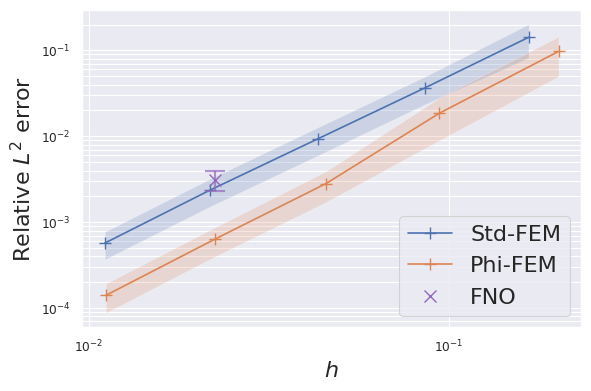

In [27]:
mean_errors_L2_phi_fem = np.mean(L2_error_phi_fem_array, axis=0)
mean_errors_L2_std_fem = np.mean(L2_error_std_fem_array, axis=0)
mean_errors_L2_FNO = np.mean(L2_error_fno_array, axis=0)

std_errors_L2_phi_fem = np.std(L2_error_phi_fem_array, axis=0)
std_errors_L2_std_fem = np.std(L2_error_std_fem_array, axis=0)
std_errors_L2_FNO = np.std(L2_error_fno_array, axis=0)

min_errors_L2_phi_fem = np.min(L2_error_phi_fem_array, axis=0)
min_errors_L2_std_fem = np.min(L2_error_std_fem_array, axis=0)
min_errors_L2_FNO = np.min(L2_error_fno_array, axis=0)

max_errors_L2_phi_fem = np.max(L2_error_phi_fem_array, axis=0)
max_errors_L2_std_fem = np.max(L2_error_std_fem_array, axis=0)
max_errors_L2_FNO = np.max(L2_error_fno_array, axis=0)

center = [size_fno, mean_errors_L2_FNO[0]]

plt.figure(figsize=(6, 4))
plt.loglog(
    sizes_std, mean_errors_L2_std_fem, "-+", markersize=8, label="Std-FEM"
)
ci_error_std_FEM = std_errors_L2_std_fem
plt.fill_between(
    sizes_std,
    mean_errors_L2_std_fem - ci_error_std_FEM,
    mean_errors_L2_std_fem + ci_error_std_FEM,
    alpha=0.2,
)
plt.loglog(
    sizes_phi_fem, mean_errors_L2_phi_fem, "-+", markersize=8, label="Phi-FEM"
)
ci_error_phi_fem = std_errors_L2_phi_fem

plt.fill_between(
    sizes_phi_fem,
    mean_errors_L2_phi_fem - ci_error_phi_fem,
    mean_errors_L2_phi_fem + ci_error_phi_fem,
    alpha=0.2,
)
plt.plot(
    size_fno,
    mean_errors_L2_FNO[-1],
    "x",
    markersize=8,
    label="FNO",
    color=sns.color_palette("tab10")[4],
)

ci = [
    mean_errors_L2_FNO[-1] + std_errors_L2_FNO[-1],
    np.absolute(mean_errors_L2_FNO[-1] - std_errors_L2_FNO[-1]),
]

plt.errorbar(
    size_fno,
    mean_errors_L2_FNO[-1],
    yerr=ci[-1],
    ecolor=sns.color_palette("tab10")[4],
    capsize=7,
    elinewidth=1.5,
    capthick=1.5,
    fmt="none",
    alpha=0.7,
)

plt.legend(fontsize=16, loc="lower right")
plt.xlabel("$h$", fontsize=16)
plt.ylabel("Relative $L^2$ error", fontsize=16)
plt.grid(axis="y", visible=True, which="both")

plt.tight_layout()
if save_figs:
    plt.savefig(f"./images/error_size_3_methods.png")
plt.show()

In [28]:
Total_time_phi_fem_array = np.zeros((Cell_selection_phi_array.shape))
Total_time_std_fem_array = np.zeros((Construction_time_standard_array.shape))

Total_time_phi_fem_array = (
    Cell_selection_phi_array
    + Submesh_construction_phi_array
    + Ghost_cell_selection_phi_array
    + Resolution_time_phi_array
)
Total_time_std_fem_array = (
    Construction_time_standard_array + Resolution_time_standard_array
)

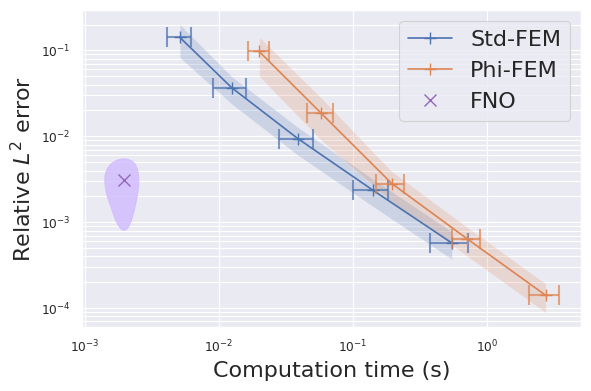

In [29]:
mean_times_L2_phi_fem = np.mean(Total_time_phi_fem_array, axis=0)
mean_times_L2_std_fem = np.mean(Total_time_std_fem_array, axis=0)
mean_times_L2_FNO = np.mean(Time_fno_array, axis=0)

std_times_L2_phi_fem = np.std(Total_time_phi_fem_array, axis=0)
std_times_L2_std_fem = np.std(Total_time_std_fem_array, axis=0)
std_times_L2_FNO = np.std(Time_fno_array, axis=0)

min_times_L2_phi_fem = np.min(Total_time_phi_fem_array, axis=0)
min_times_L2_std_fem = np.min(Total_time_std_fem_array, axis=0)
min_times_L2_FNO = np.min(Time_fno_array, axis=0)

max_times_L2_phi_fem = np.max(Total_time_phi_fem_array, axis=0)
max_times_L2_std_fem = np.max(Total_time_std_fem_array, axis=0)
max_times_L2_FNO = np.max(Time_fno_array, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ci_error_std_FEM = std_errors_L2_std_fem
ci_time_std_FEM = std_times_L2_std_fem

ax.loglog(
    mean_times_L2_std_fem,
    mean_errors_L2_std_fem,
    "-+",
    markersize=8,
    label="Std-FEM",
)
ax.fill_between(
    mean_times_L2_std_fem,
    mean_errors_L2_std_fem - ci_error_std_FEM,
    mean_errors_L2_std_fem + ci_error_std_FEM,
    alpha=0.2,
)
ax.errorbar(
    mean_times_L2_std_fem,
    mean_errors_L2_std_fem,
    xerr=ci_time_std_FEM,
    ecolor=sns.color_palette()[0],
    capsize=7,
    elinewidth=1.5,
    capthick=1.5,
    fmt="none",
    alpha=0.7,
)

ax.loglog(
    mean_times_L2_phi_fem,
    mean_errors_L2_phi_fem,
    "-+",
    markersize=8,
    label="Phi-FEM",
)

ci_error_phi_FEM = std_errors_L2_phi_fem
ci_time_phi_FEM = std_times_L2_phi_fem

ax.fill_between(
    mean_times_L2_phi_fem,
    mean_errors_L2_phi_fem - ci_error_phi_FEM,
    mean_errors_L2_phi_fem + ci_error_phi_FEM,
    alpha=0.2,
)
ax.errorbar(
    mean_times_L2_phi_fem,
    mean_errors_L2_phi_fem,
    xerr=ci_time_phi_FEM,
    ecolor=sns.color_palette()[1],
    capsize=7,
    elinewidth=1.5,
    capthick=1.5,
    fmt="none",
    alpha=0.7,
)

ax.plot(
    mean_times_L2_FNO[-1],
    mean_errors_L2_FNO[-1],
    "x",
    markersize=8,
    label="FNO",
    color=sns.color_palette("tab10")[4],
)
confidence_ellipse(
    Time_fno_array[:, -1],
    L2_error_fno_array[:, -1],
    ax,
    alpha=0.8,
    facecolor=sns.color_palette("pastel")[4],
    edgecolor=sns.color_palette("pastel")[4],
)


ax.legend(fontsize=16, loc="upper right")
ax.set_xlabel("Computation time (s)", fontsize=16)
ax.set_ylabel("Relative $L^2$ error", fontsize=16)
plt.grid(axis="y", visible=True, which="both")
plt.tight_layout()
if save_figs:
    plt.savefig(f"./images/error_time_3_methods.png")
plt.show()